## Access to Special Healthcare Services Among Children

Access to specialized healthcare services is a critical aspect of ensuring the well-being of children, particularly those with chronic conditions or disabilities. However, disparities in healthcare access can significantly impact health outcomes, creating challenges for families seeking appropriate care for their children. This capstone project aims to leverage data from  National Survey of Children's Health (NSCH) to shed light on the sociodemographic characteristics of children facing special healthcare needs.

### Getting Started:
The project will utilize the comprehensive dataset of the NSCH from years 2016-2021, a nationally representative survey encompassing information on the health and well-being of over 200k+ children. By focusing on children with special healthcare needs, chronic conditions, and exploring factors such as public insurance coverage, the analysis will delve into the barriers faced by parents in accessing specialized healthcare services for their children.

### Project Approach:
By observing and analyzing trends over the years, the project will unveil the dynamics of how access to specialized healthcare services has evolved. This temporal perspective allows for a nuanced understanding of any changes or persistent challenges in healthcare access for children with special needs.



In [1]:
!pip install xgboost

In [7]:
!pip install --upgrade keras tensorflow
!pip install tensorflow>=2.0
!pip install scikeras

  Using cached keras-3.0.1-py3-none-any.whl (999 kB)
  Using cached namex-0.0.7-py3-none-any.whl (5.8 kB)


In [16]:
!pip install tensorflow

  Using cached tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from xgboost import XGBRegressor
from scikeras.wrappers import KerasRegressor


# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data_consolidated.csv')
df.head()

,HHID,FIPSST,STRATUM,FORMTYPE,TOTKIDS_R,HHLANGUAGE,SC_AGE_YEARS,SC_SEX,MOMAGE,LIVEUSA_YR,...,rxmeds,serve,func,therapy,mhealth,qualnum,CSHCN,CSHCNtype,CSHCNComplex,mhneeds
0,16000030,18,1,1,1,1,2,1,28,95,...,2,2,2,2,2,0,2,0,3,3
1,16000032,17,1,2,1,1,9,1,40,95,...,1,1,2,1,1,4,1,4,1,1
2,16000050,50,1,2,1,1,11,1,28,95,...,2,2,2,2,2,0,2,0,3,3
3,16000051,51,1,2,3,1,10,2,37,95,...,2,2,2,2,2,0,2,0,3,3
4,16000090,53,1,3,1,1,15,2,30,95,...,2,2,2,2,2,0,2,0,3,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225443 entries, 0 to 225442
Data columns (total 39 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   HHID          225443 non-null  int64
 1   FIPSST        225443 non-null  int64
 2   STRATUM       225443 non-null  int64
 3   FORMTYPE      225443 non-null  int64
 4   TOTKIDS_R     225443 non-null  int64
 5   HHLANGUAGE    225443 non-null  int64
 6   SC_AGE_YEARS  225443 non-null  int64
 7   SC_SEX        225443 non-null  int64
 8   MOMAGE        225443 non-null  int64
 9   LIVEUSA_YR    225443 non-null  int64
 10  LIVEUSA_MO    225443 non-null  int64
 11  HHCOUNT       225443 non-null  int64
 12  FAMCOUNT      225443 non-null  int64
 13  SC_CSHCN      225443 non-null  int64
 14  SC_K2Q10      225443 non-null  int64
 15  SC_K2Q11      225443 non-null  int64
 16  SC_K2Q12      225443 non-null  int64
 17  SC_K2Q13      225443 non-null  int64
 18  SC_K2Q14      225443 non-null  int64
 19  SC

In [4]:
# Find missing values in each column
missing_values = df.isnull().sum()

# Check and print the results
missing_columns = missing_values[missing_values > 0]

if missing_columns.empty:
    print("######################################")
    print("No missing values in the dataset")
    print("######################################")
else:
    print("######################################")
    print("Columns with missing values:")
    print(missing_columns)
    print("######################################")

# Get the non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['number'])
print("\n")
print("######################################")
print("Non numeric columns in dataset" , len(non_numeric_columns.columns) , "non-numeric columns")
print("######################################")

print("\n")
# Describing the data
print("########################  Describing the data ###########################")
print(df.describe().T)
print("#########################################################################")

print("\n")
print("########################  Removing the duplicate columns - 'CSHCN' ###########################")
print((df['CSHCN'] == df['SC_CSHCN']).value_counts())


# Dropping year as this YEAR has only 2016

columns_to_drop = ['CSHCN']

df = df.drop(columns=columns_to_drop)

print("####################################################################################################################")


######################################
No missing values in the dataset
######################################


######################################
Non numeric columns in dataset 0 non-numeric columns
######################################


########################  Describing the data ###########################
                 count          mean           std         min         25%  \
HHID          225443.0  1.877563e+07  1.863268e+06  16000030.0  17047932.5   
FIPSST        225443.0  2.924999e+01  1.571184e+01         1.0        16.0   
STRATUM       225443.0  1.069893e+00  2.549680e-01         1.0         1.0   
FORMTYPE      225443.0  2.079284e+00  8.344768e-01         1.0         1.0   
TOTKIDS_R     225443.0  1.853506e+00  8.672497e-01         1.0         1.0   
HHLANGUAGE    225443.0  1.631184e+00  7.164125e+00         1.0         1.0   
SC_AGE_YEARS  225443.0  9.152203e+00  5.260430e+00         0.0         4.0   
SC_SEX        225443.0  1.482477e+00  4.996939e-01      

### Understanding if there is any imbalance in the target variable

In [5]:
print("\n")
# Understanding if there is any imbalance in the target variable
print("##########################  Class Imbalance of Target variable  ############################")
print(df['SC_CSHCN'].value_counts() ,  '  And the ratio is  ' , (df['SC_CSHCN'] == 1).sum()/(df['SC_CSHCN'] == 2).sum())
print("#############################################################################################")



##########################  Class Imbalance of Target variable  ############################
2    173926
1     51517
Name: SC_CSHCN, dtype: int64   And the ratio is   0.29620068304911285
#############################################################################################


### Checking for duplicates and finding the coorelation of matrix

Shape before deleting the duplicates from dataset (225443, 38)
Shape after deleting the duplicates from dataset (225443, 38)


################## Correlation of the matrix ####################


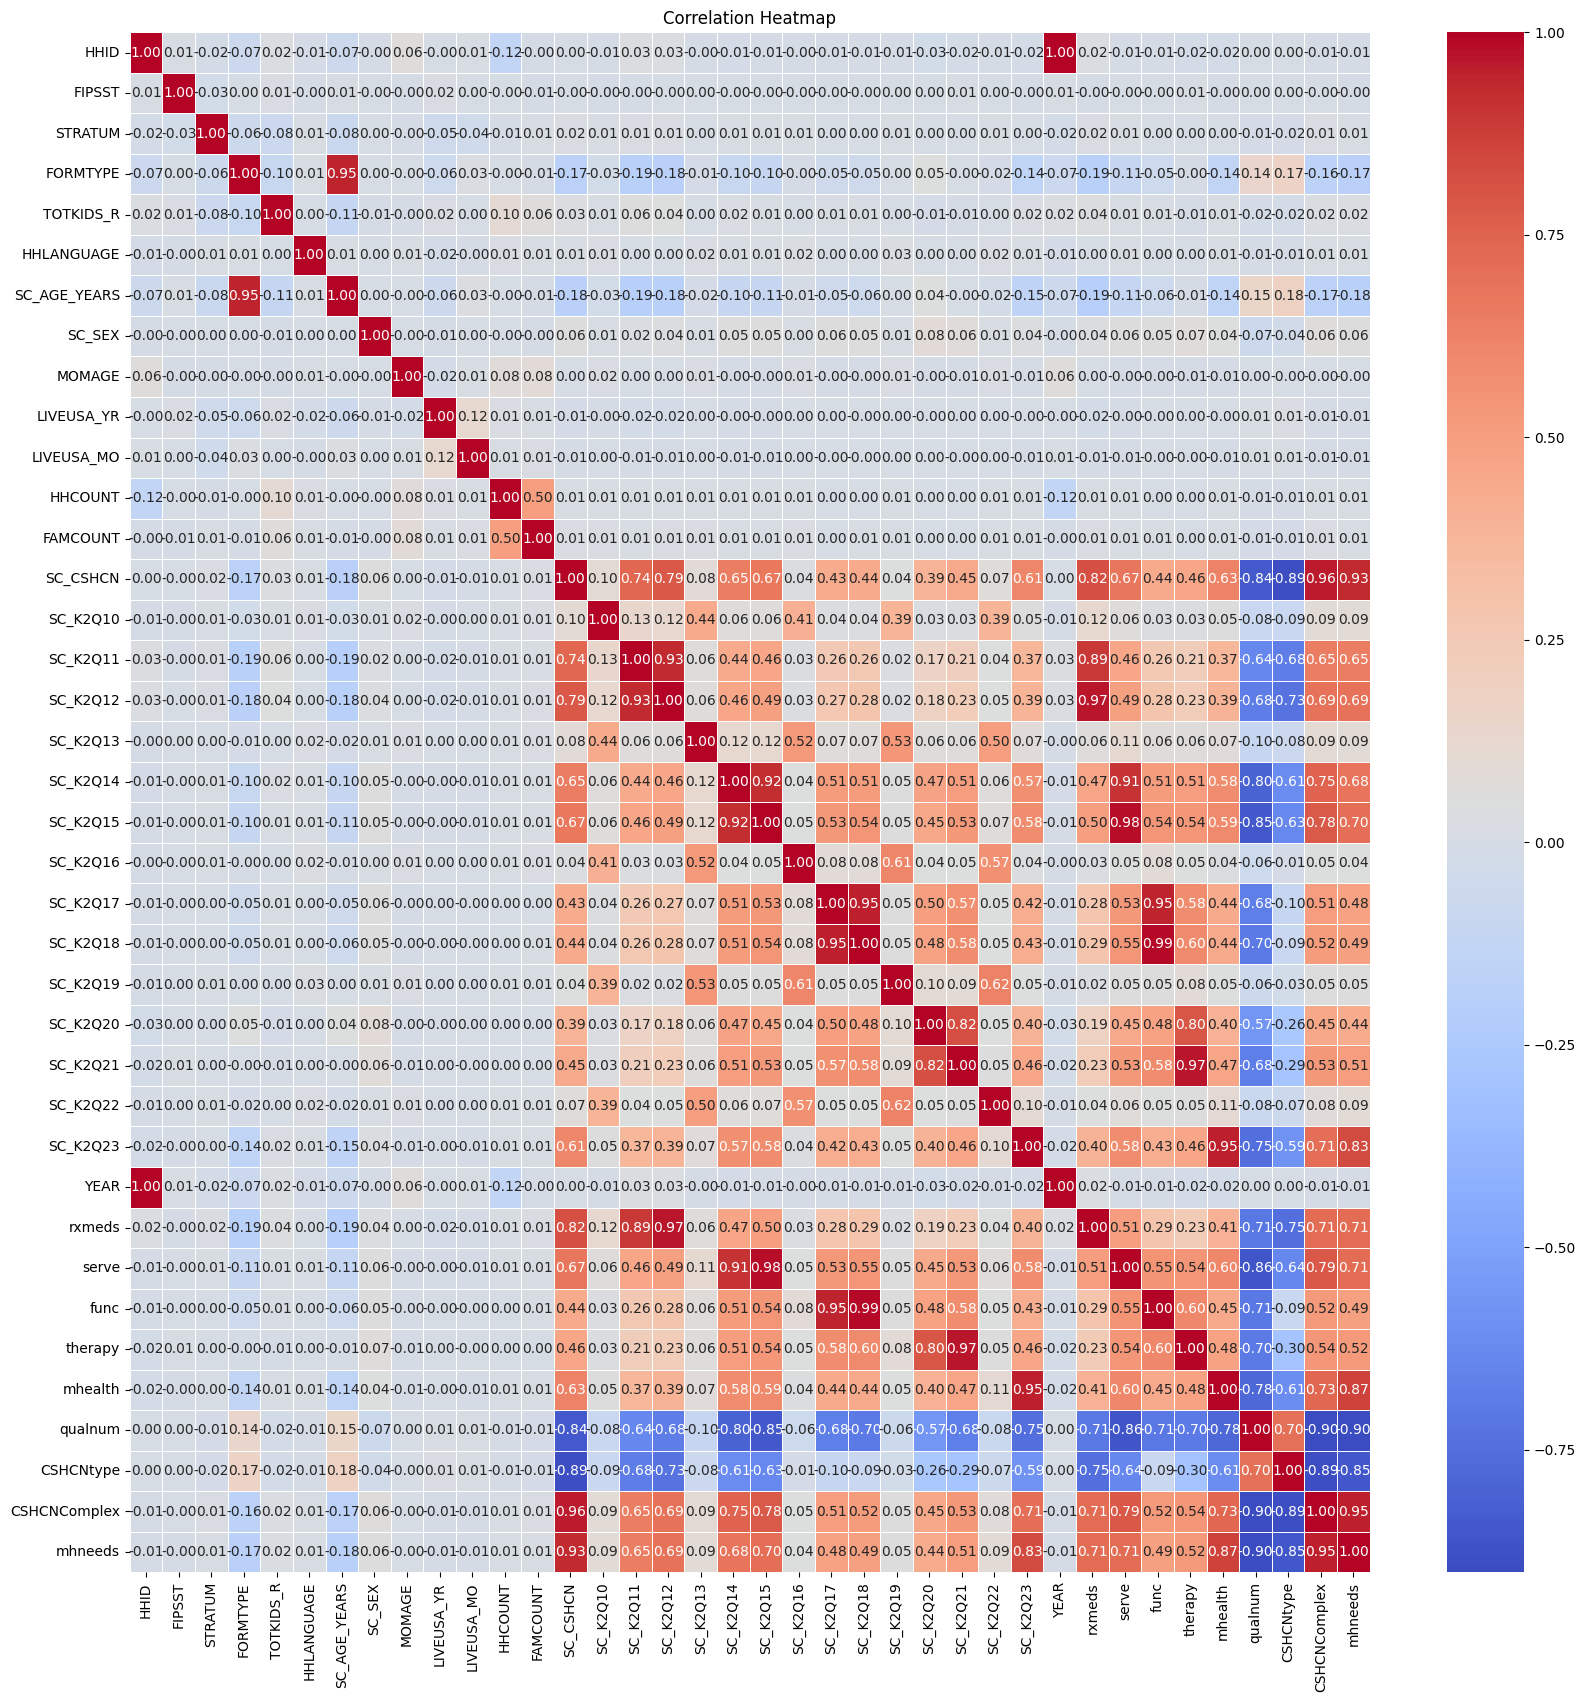

In [6]:
print("Shape before deleting the duplicates from dataset", df.shape)
df.drop_duplicates(inplace=True)
print("Shape after deleting the duplicates from dataset", df.shape)

print("\n")
print("################## Correlation of the matrix ####################")
cormat=df.corr(numeric_only=True)
# Create a heatmap
plt.figure(figsize=(20, 20))  # Adjust the figure size as needed
sns.heatmap(cormat, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

#### Observations

1. Target variable SC_CSHCN is coorelated with SC_K* variables, rxmeds, serve , therapy, funcm mhealth and qualnum variables
2. AGE and SEX of the kid is needed, but not highly coorelated

### Analyze the dataset over the years to understand trends

In [7]:
# Count the affected children for each year
df_year_counts = df['YEAR'].value_counts().sort_index()
affected_children = df[df['SC_CSHCN'] == 1]
affected_children_counts = affected_children['YEAR'].value_counts().sort_index()

# Calculate the percentages
percentage_affected_children = (affected_children_counts / df_year_counts) * 100

# Calculate boy and girl percentages
affected_children_gender_counts = affected_children.groupby(['YEAR', 'SC_SEX']).size().unstack(fill_value=0)
percentage_boys = (affected_children_gender_counts[1] / affected_children_counts) * 100
percentage_girls = (affected_children_gender_counts[2] / affected_children_counts) * 100


# Create a table using pandas DataFrame
table_data = pd.DataFrame({
    'Year': df_year_counts.index,
    'Total Number of Children': df_year_counts.values,
    'Number of Affected Children': affected_children_counts.values,
    'Percentage of Affected Children': percentage_affected_children.values,
    'Percentage of Boys': percentage_boys.values,
    'Percentage of Girls': percentage_girls.values
})


# Display the table
print(table_data)

   Year  Total Number of Children  Number of Affected Children  \
0  2016                     50212                        11392   
1  2017                     21599                         4912   
2  2018                     30530                         6976   
3  2019                     29433                         7021   
4  2020                     42777                        10044   
5  2021                     50892                        11172   

   Percentage of Affected Children  Percentage of Boys  Percentage of Girls  
0                        22.687804           56.460674            43.539326  
1                        22.741794           56.229642            43.770358  
2                        22.849656           57.282110            42.717890  
3                        23.854177           56.971941            43.028059  
4                        23.479907           56.680605            43.319395  
5                        21.952370           57.142857            42.

#### Observations from above results

The table provides a summary of the total number of children surveyed each year, along with the corresponding number of affected children and the calculated percentages. The key points from the summary are as follows:

* In 2016, out of 50,212 children surveyed, 11,392 were affected, constituting approximately 22.69% of the total.
* The percentage of affected children remained relatively stable over the years, ranging from 22.69% to 23.85%.
* The number of affected children in 2021 was 11,172, representing 21.95% of the 50,892 children surveyed.
* The percentage distribution between boys and girls among affected children varied, with boys consistently having a slightly higher percentage than girls.

Overall, the summary provides insights into the prevalence of affected children over the years and the distribution of affected children by gender.

### Analyze the dataset over the years to understand trends using graphs

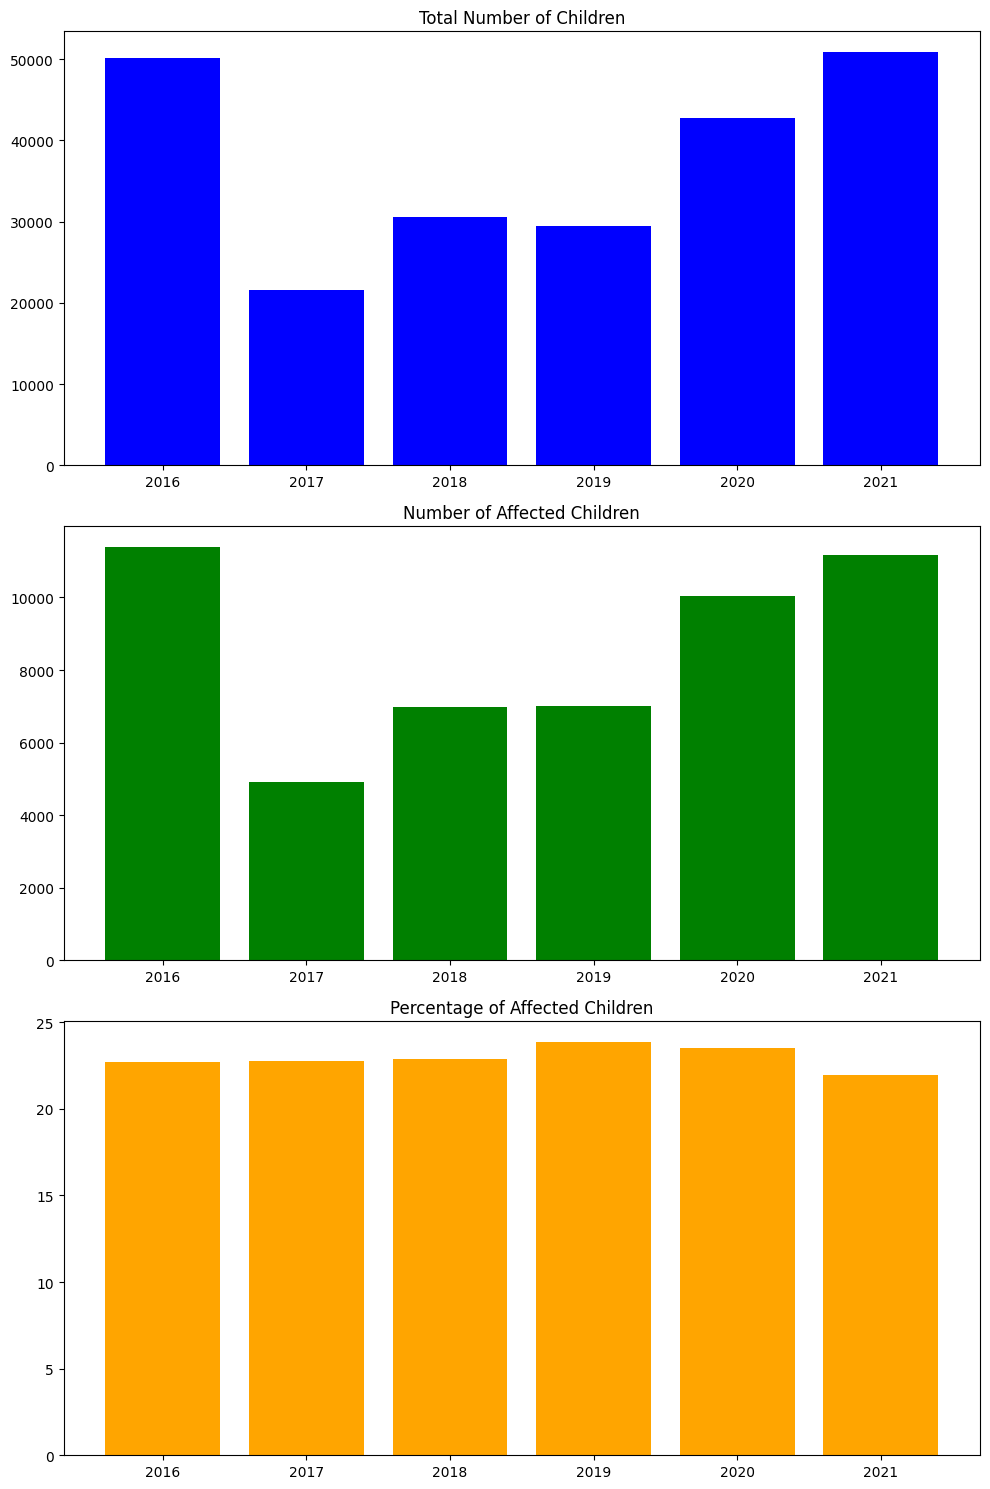

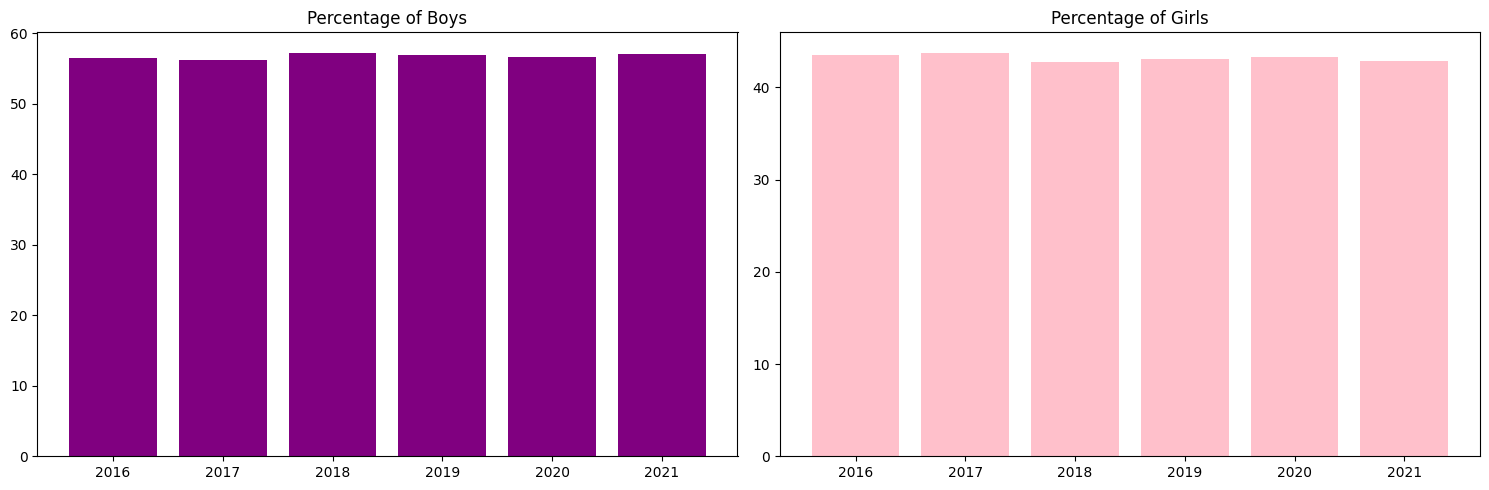

In [8]:
import matplotlib.pyplot as plt

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot Total Number of Children
axes[0].bar(table_data['Year'], table_data['Total Number of Children'], color='blue')
axes[0].set_title('Total Number of Children')

# Plot Number of Affected Children
axes[1].bar(table_data['Year'], table_data['Number of Affected Children'], color='green')
axes[1].set_title('Number of Affected Children')

# Plot Percentage of Affected Children
axes[2].bar(table_data['Year'], table_data['Percentage of Affected Children'], color='orange')
axes[2].set_title('Percentage of Affected Children')

# Adjust layout
plt.tight_layout()
plt.show()

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot Percentage of Boys
axes[0].bar(table_data['Year'], table_data['Percentage of Boys'], color='purple')
axes[0].set_title('Percentage of Boys')

# Plot Percentage of Girls
axes[1].bar(table_data['Year'], table_data['Percentage of Girls'], color='pink')
axes[1].set_title('Percentage of Girls')

# Adjust layout
plt.tight_layout()
plt.show()


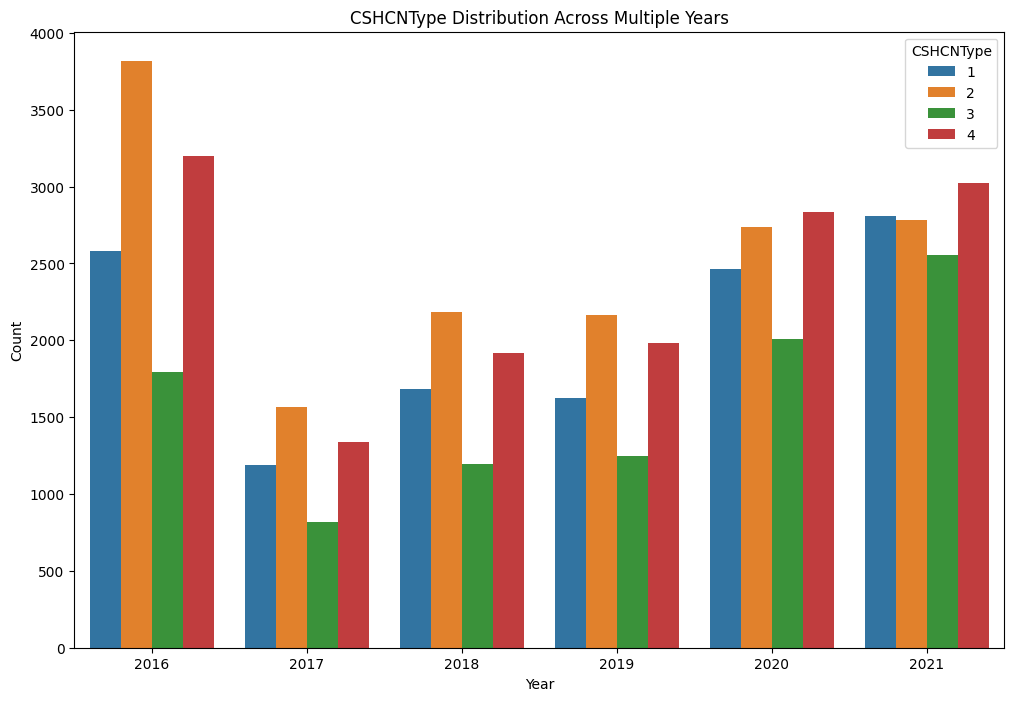

In [13]:

# Create a count plot to show 'CSHCNType' distribution across multiple years
filtered_df = df[df['CSHCNtype'] != 0]
plt.figure(figsize=(12, 8))
sns.countplot(x='YEAR', hue='CSHCNtype', data=filtered_df)
plt.title('CSHCNType Distribution Across Multiple Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='CSHCNType')
plt.show()


Percentage of Affected Children by CSHCNType Across Multiple Years
CSHCNtype         1         2         3         4
YEAR                                             
2016       5.136222  7.601769  3.572851  6.376962
2017       5.514144  7.236446  3.796472  6.194731
2018       5.509335  7.156895  3.907632  6.275794
2019       5.524411  7.352292  4.236741  6.740733
2020       5.757767  6.402974  4.694111  6.625056
2021       5.521497  5.464513  5.022400  5.943960




<Figure size 1200x800 with 0 Axes>

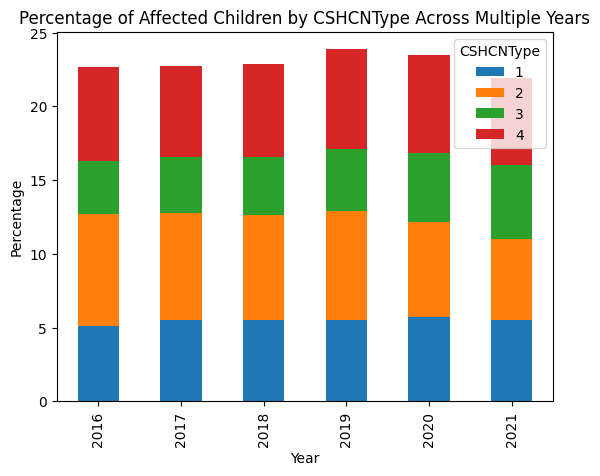

In [9]:
# Filter out rows where 'CSHCNtype' is 0
filtered_df = df[df['CSHCNtype'] != 0]

# Calculate the percentage of affected children for each 'CSHCNType' across years
percentage_by_type = (filtered_df.groupby(['YEAR', 'CSHCNtype']).size() / df.groupby('YEAR').size() * 100).unstack(fill_value=0)

print('Percentage of Affected Children by CSHCNType Across Multiple Years')
print(percentage_by_type)
print("\n")
# Create a stacked bar chart
plt.figure(figsize=(12, 8))
percentage_by_type.plot(kind='bar', stacked=True)
plt.title('Percentage of Affected Children by CSHCNType Across Multiple Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='CSHCNType')
plt.show()

### Utilizing ARIMA and other forecasting models like LSTM, XGBoost models to predict future values for 2021 and 2022.

Number of children affected by year - Real data 
YEAR
2016-01-01    11392
2017-01-01     4912
2018-01-01     6976
2019-01-01     7021
2020-01-01    10044
2021-01-01    11172
dtype: int64
Number of children affected by year - Survey(Real) + Forecasted data 
2016-01-01    11392.000000
2017-01-01     4912.000000
2018-01-01     6976.000000
2019-01-01     7021.000000
2020-01-01    10044.000000
2021-01-01    10658.959323
2022-01-01    13265.498834
2023-01-01    14224.893559
dtype: float64


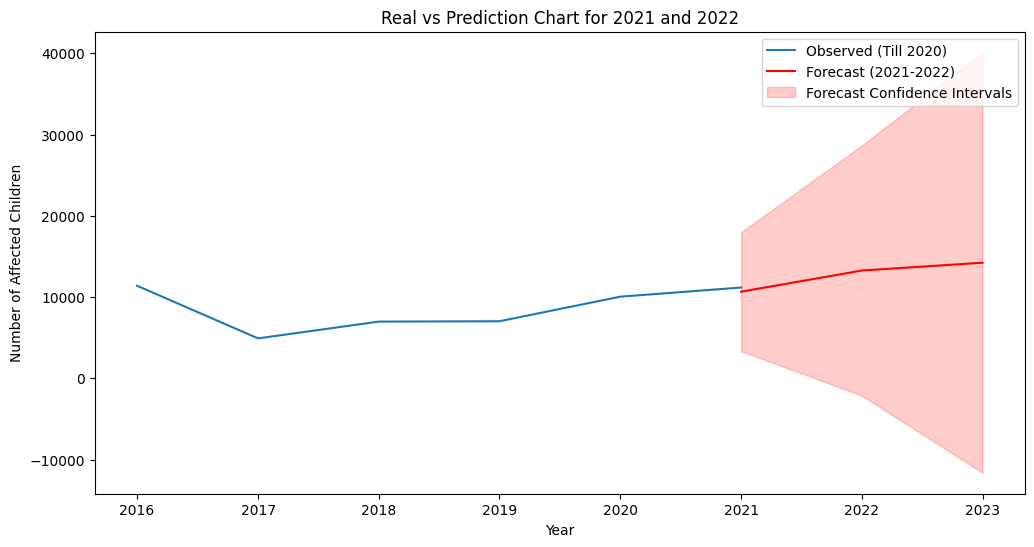

In [10]:
#ARIMA Model

# Assuming your original DataFrame is named 'df' and has a 'YEAR' column
# Ensure the 'YEAR' column is of datetime type, if not, convert it
df['YEAR'] = pd.to_datetime(df['YEAR'], format='%Y')


# Extract relevant columns and data only for rows where SC_CSHCN is 1 and till 2020
time_series_data = df[(df['YEAR'] <= '2020') & (df['SC_CSHCN'] == 1)].groupby('YEAR').size()

time_series_data_full = df[(df['SC_CSHCN'] == 1)].groupby('YEAR').size()
print("Number of children affected by year - Real data ")
print(time_series_data_full)
# Assuming 'time_series_data' is your time series
differenced_series = time_series_data.diff().dropna()

# Define the ARIMA model
model = ARIMA(differenced_series, order=(1, 1, 1))  # Adjust order as needed

# Fit the model
model_fit = model.fit()

# Forecast for 2021, 2022, 2023
forecast_steps = 3  # Forecast for 2021 and 2022
forecast = model_fit.get_forecast(steps=forecast_steps)

# Extract forecast values and confidence intervals on the differenced scale
forecast_values_diff = forecast.predicted_mean
confidence_intervals_diff = forecast.conf_int()

# Integrate differencing to obtain forecast values and confidence intervals in the original scale
forecast_values = time_series_data.iloc[-1] + np.cumsum(forecast_values_diff)
confidence_intervals = time_series_data.iloc[-1] + np.cumsum(confidence_intervals_diff)


# Add the forecast values to the original time series
extended_time_series = time_series_data.append(forecast_values)
print("Number of children affected by year - Survey(Real) + Forecasted data ")
print(extended_time_series)

# Plot real vs prediction chart
plt.figure(figsize=(12, 6))
plt.plot(time_series_data_full.index, time_series_data_full, label='Observed (Till 2020)')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast (2021-2022)')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='red', alpha=0.2, label='Forecast Confidence Intervals')
plt.title('Real vs Prediction Chart for 2021 and 2022')
plt.xlabel('Year')
plt.ylabel('Number of Affected Children')
plt.legend()
plt.show()

### Observation

For the specific case, where the actual value for 2021 is 11172 and the forecasted value is 10658, the Absolute Error is: 514 , where as Mean square error - MSE=(11172−10658)^2 = 264196

Number of children affected by year - Real data 
YEAR
2016-01-01    11392
2017-01-01     4912
2018-01-01     6976
2019-01-01     7021
2020-01-01    10044
2021-01-01    11172
dtype: int64
Forecast data: 
 DatetimeIndex(['2021-12-31', '2022-12-31', '2023-12-31'], dtype='datetime64[ns]', freq='A-DEC') [[8671.618]
 [8596.747]
 [8411.978]]


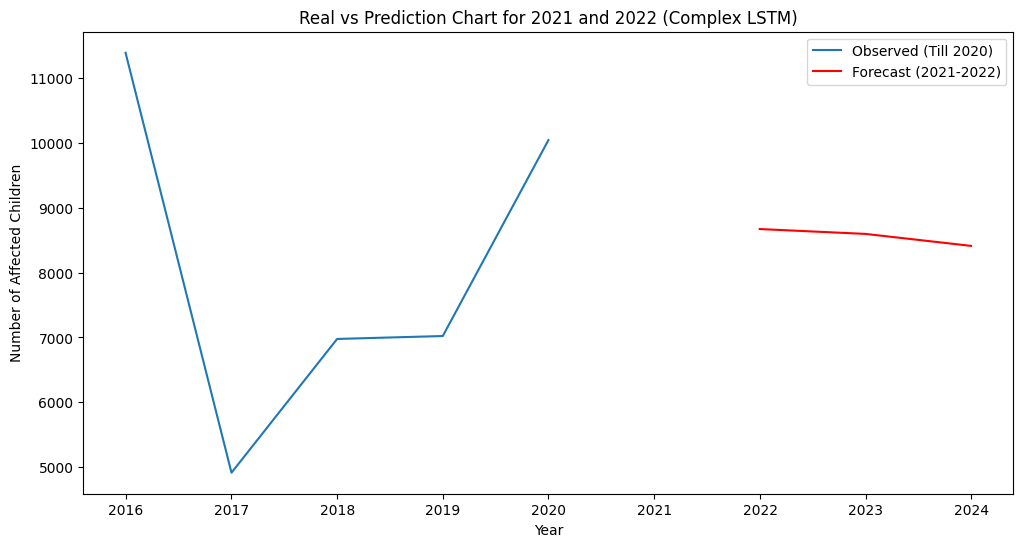

In [13]:
# LSTM Model


# Assuming 'time_series_data' is your time series
time_series_data = df[(df['YEAR'] <= '2020') & (df['SC_CSHCN'] == 1)].groupby('YEAR').size()

# Normalize the time series data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(time_series_data).reshape(-1, 1))

# Prepare the data for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 3  # Number of time steps to consider for each sample
X, y = create_sequences(scaled_data, n_steps)

# Reshape input data to be 3D [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build a more complex LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=100, verbose=0)

# Forecast for 2021, 2022, 2023
forecast_steps = 3
forecast_input = scaled_data[-n_steps:]
forecast_input = forecast_input.reshape((1, n_steps, 1))

forecast_scaled = []
for _ in range(forecast_steps):
    forecast_value = model.predict(forecast_input, verbose=0)
    forecast_scaled.append(forecast_value)
    forecast_input = np.append(forecast_input[:, 1:, :], forecast_value.reshape((1, 1, 1)), axis=1)

# Invert the scaling
forecast_values = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Create years for the forecasted data
forecast_years = pd.date_range(start='2021-01-01', periods=forecast_steps, freq='Y')

print("Number of children affected by year - Real data ")
print(time_series_data_full)
print("Forecast data: \n", forecast_years, forecast_values )


# Plot real vs prediction chart
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Observed (Till 2020)')
plt.plot(forecast_years, forecast_values, color='red', label='Forecast (2021-2022)')
plt.title('Real vs Prediction Chart for 2021 and 2022 (Complex LSTM)')
plt.xlabel('Year')
plt.ylabel('Number of Affected Children')
plt.legend()
plt.show()


#### Observation

For the specific case, where the actual value for 2021 is 11172 and the forecasted value is 8671, the Absolute Error is: 2501 , where as Mean square error - MSE=(11172−8671)^2 = 6255001

Number of children affected by year - Real data 
YEAR
2016-01-01    11392
2017-01-01     4912
2018-01-01     6976
2019-01-01     7021
2020-01-01    10044
2021-01-01    11172
dtype: int64
Forecast data: 
 DatetimeIndex(['2021-12-31', '2022-12-31', '2023-12-31'], dtype='datetime64[ns]', freq='A-DEC') [[7021.]
 [7021.]
 [7021.]]


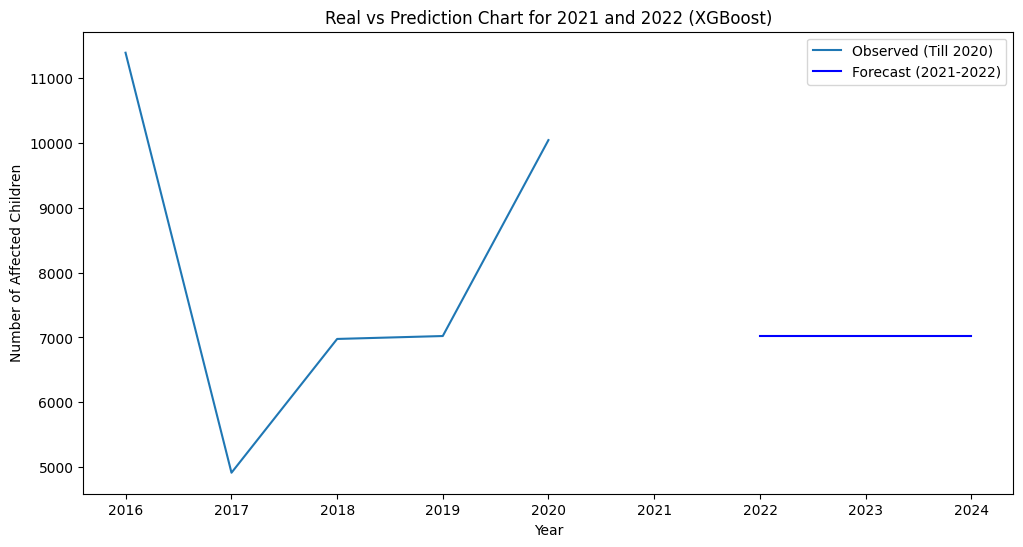

In [18]:
# Assuming 'time_series_data' is your time series
time_series_data = df[(df['YEAR'] <= '2020') & (df['SC_CSHCN'] == 1)].groupby('YEAR').size()

# Normalize the time series data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(time_series_data).reshape(-1, 1))

# Prepare the data for XGBoost
X, y = [], []
for i in range(len(scaled_data) - 3):
    X.append(scaled_data[i:i+3, 0])
    y.append(scaled_data[i+3, 0])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the XGBoost model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Forecast for 2021, 2022, 2023
forecast_steps = 3
forecast_input = scaled_data[-3:].reshape((1, 3))  # Use 3 features for prediction

forecast_scaled = []
for _ in range(forecast_steps):
    forecast_value = model.predict(forecast_input)
    forecast_scaled.append(forecast_value)
    forecast_input = np.append(forecast_input[:, 1:], forecast_value).reshape((1, 3))  # Maintain the shape

# Invert the scaling
forecast_values = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Create years for the forecasted data
forecast_years = pd.date_range(start='2021-01-01', periods=forecast_steps, freq='Y')

print("Number of children affected by year - Real data ")
print(time_series_data_full)
print("Forecast data: \n", forecast_years, forecast_values )

# Plot real vs prediction chart
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Observed (Till 2020)')
plt.plot(forecast_years, forecast_values, color='blue', label='Forecast (2021-2022)')
plt.title('Real vs Prediction Chart for 2021 and 2022 (XGBoost)')
plt.xlabel('Year')
plt.ylabel('Number of Affected Children')
plt.legend()
plt.show()


#### Observation

For the specific case, where the actual value for 2021 is 11172 and the forecasted value is 7201, the Absolute Error is: 3971 , where as Mean square error - MSE=(11172−8671)^2 = 15775721

### Summary and Next Steps/Recommendations

Based on the error metrics for ARIMA, LSTM, and XGBoost models:

**ARIMA:**
Absolute Error (AE): 514
Mean Squared Error (MSE): 264,196

**LSTM:**
Absolute Error (AE): 2,501
Mean Squared Error (MSE): 6,255,001

**XGBoost:**
Absolute Error (AE): 3,971
Mean Squared Error (MSE): 15,775,721

**Summary:**

1. The ARIMA model has the lowest absolute error and mean squared error among the three models.
2. The LSTM model has a higher absolute error and mean squared error compared to ARIMA but performs better than XGBoost.
3. The XGBoost model shows the highest absolute error and mean squared error.

**Next Steps:**

1. **Parameter Tuning:** For LSTM and XGBoost, consider tuning hyperparameters to potentially improve performance.

2. **Ensemble Methods:** Explore ensemble methods that combine the predictions of multiple models. This may improve overall forecasting accuracy.

3. **Feature Engineering:** For XGBoost, try different sets of features or additional feature engineering to enhance predictive power.
Data Exploration:



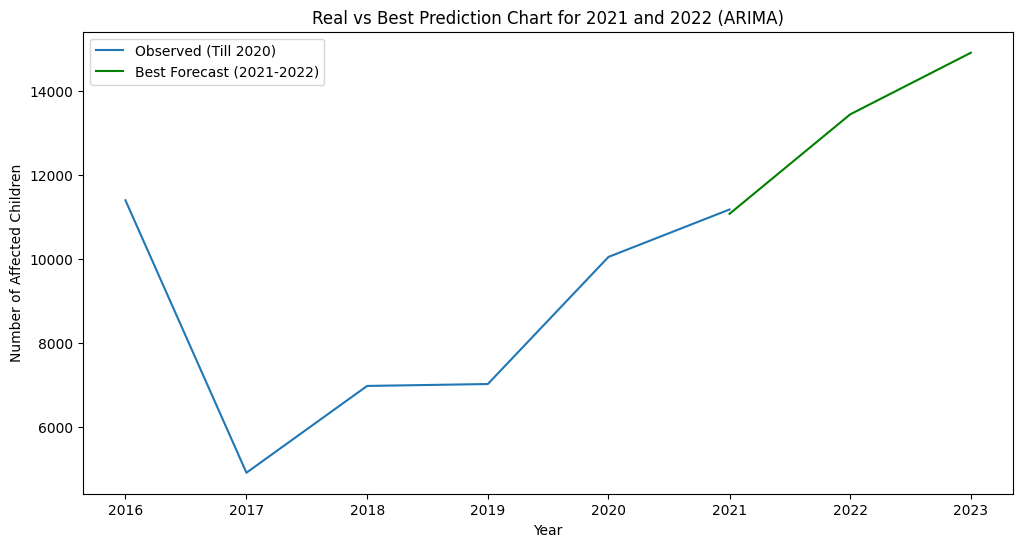

Best ARIMA Order: (1, 1, 0)
Forecasted Value for 2021: 2021-01-01    10658.959323
dtype: float64
Real Value for 2021: YEAR
2021-01-01    11172
dtype: int64


In [20]:
import itertools

# Define the range of values for p, d, q
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Generate all possible combinations of p, d, q
orders = list(itertools.product(p_values, d_values, q_values))

# Set initial values for best model
best_score, best_cfg = float('inf'), None

# Loop over all combinations
for order in orders:
    try:
        # Fit ARIMA model with the current order
        model = ARIMA(differenced_series, order=order)
        model_fit = model.fit()

        # Evaluate performance (e.g., using AIC or BIC)
        score = model_fit.aic

        # Update best_score and best_cfg if performance improves
        if score < best_score:
            best_score, best_cfg = score, order

    except:
        continue

# Fit the best model
best_model = ARIMA(differenced_series, order=best_cfg)
best_model_fit = best_model.fit()

# Forecast for 2021, 2022, 2023 using the best model
best_forecast = best_model_fit.get_forecast(steps=forecast_steps)
best_forecast_values_diff = best_forecast.predicted_mean
best_forecast_values = time_series_data.iloc[-1] + np.cumsum(best_forecast_values_diff)

# Plot real vs best prediction chart
plt.figure(figsize=(12, 6))
plt.plot(time_series_data_full.index, time_series_data_full, label='Observed (Till 2020)')
plt.plot(best_forecast_values.index, best_forecast_values, color='green', label='Best Forecast (2021-2022)')
plt.title('Real vs Best Prediction Chart for 2021 and 2022 (ARIMA)')
plt.xlabel('Year')
plt.ylabel('Number of Affected Children')
plt.legend()
plt.show()

print("Best ARIMA Order:", best_cfg)

# Assuming 'extended_time_series' includes the forecasted values
forecasted_value_2021 = extended_time_series.loc['2021']
real_value_2021 = time_series_data_full.loc['2021']

print(f"Forecasted Value for 2021: {forecasted_value_2021}")
print(f"Real Value for 2021: {real_value_2021}")



Best Parameters:  {'activation': 'tanh', 'units': 50}
Number of children affected by year - Real data 
YEAR
2016-01-01    11392
2017-01-01     4912
2018-01-01     6976
2019-01-01     7021
2020-01-01    10044
2021-01-01    11172
dtype: int64
Forecast data: 
 DatetimeIndex(['2021-12-31', '2022-12-31', '2023-12-31'], dtype='datetime64[ns]', freq='A-DEC') [[8737.739 ]
 [8034.1025]
 [6788.187 ]]


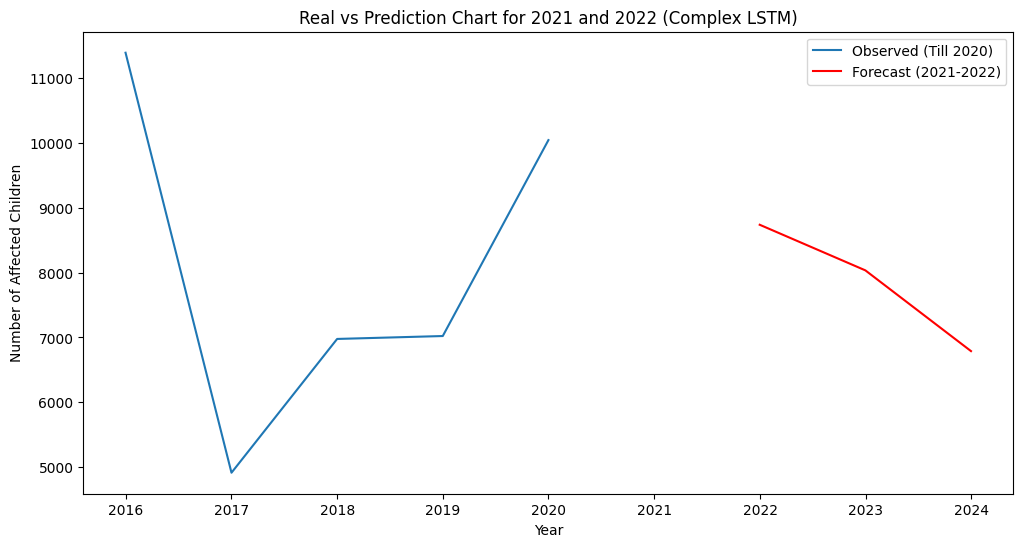

In [28]:
# Assuming 'time_series_data' is your time series
time_series_data = df[(df['YEAR'] <= '2020') & (df['SC_CSHCN'] == 1)].groupby('YEAR').size()

# Normalize the time series data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(time_series_data).reshape(-1, 1))

# Prepare the data for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 3  # Number of time steps to consider for each sample
X, y = create_sequences(scaled_data, n_steps)

# Reshape input data to be 3D [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define the LSTM model
def create_lstm_model(activation='relu', units=50):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(n_steps, 1)))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Wrap the function as a KerasRegressor
def build_model(activation='relu', units=50):
    return KerasRegressor(build_fn=create_lstm_model, activation=activation, units=units, epochs=100, batch_size=1, verbose=0)

param_grid = {
    'activation': ['relu', 'tanh'],
    'units': [50, 100]
}

# Use TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)
# Define KFold cross-validator
kf = KFold(n_splits=2, shuffle=True, random_state=42)
# Use KerasRegressor directly within GridSearchCV
grid = GridSearchCV(estimator=build_model(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=kf)
grid_result = grid.fit(X, y)

# Print the best parameters
print("Best Parameters: ", grid_result.best_params_)

# Get the best LSTM model
best_lstm_model = grid_result.best_estimator_

# Forecast for 2021, 2022, 2023
forecast_steps = 3
forecast_input = scaled_data[-n_steps:]
forecast_input = forecast_input.reshape((1, n_steps, 1))

forecast_scaled = []
for _ in range(forecast_steps):
    forecast_value = best_lstm_model.predict(forecast_input, verbose=0)
    forecast_scaled.append(forecast_value)
    forecast_input = np.append(forecast_input[:, 1:, :], forecast_value.reshape((1, 1, 1)), axis=1)

# Invert the scaling
forecast_values = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Create years for the forecasted data
forecast_years = pd.date_range(start='2021-01-01', periods=forecast_steps, freq='Y')

print("Number of children affected by year - Real data ")
print(time_series_data_full)
print("Forecast data: \n", forecast_years, forecast_values )

# Plot real vs prediction chart
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Observed (Till 2020)')
plt.plot(forecast_years, forecast_values, color='red', label='Forecast (2021-2022)')
plt.title('Real vs Prediction Chart for 2021 and 2022 (Complex LSTM)')
plt.xlabel('Year')
plt.ylabel('Number of Affected Children')
plt.legend()
plt.show()


### Summary of models with hyperparameter usage:

**ARIMA** model with the optimal order of (1, 1, 0):

Forecasted value for 2021: 10658.959323
Real value for 2021: 11172
Mean Squared Error (MSE) = (11172 - 10658.959323)^2 = 264196.1604
Mean Absolute Error (MAE) = |11172 - 10658.959323| = 513.040677

**LSTM** model:

Forecasted value for 2021: 8737.739
Real value for 2021: 11172
Mean Squared Error (MSE) = (11172 - 8737.739)^2 = 1380341.796081
Mean Absolute Error (MAE) = |11172 - 8737.739| = 2434.260677

These metrics provide an assessment of the models' accuracy, with lower MSE and MAE values indicating better performance. The ARIMA model exhibits a smaller MAE compared to the LSTM model, suggesting it may be more accurate in this specific forecasting task for the year 2021.

**Next Steps**

**Ensemble Methods:** Explore ensemble methods such as combining the predictions of multiple models (ARIMA, LSTM) to potentially improve overall forecasting accuracy.

**External Factors:** Consider if there are external factors influencing the time series that are not currently incorporated into the models. Adding relevant external features might enhance forecasting accuracy.